## EDA & Data cleaning

In [4]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
import string
import nltk
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = [json.loads(line) for line in open('reviews_Electronics_5.json', 'r')]

In [6]:
df = pd.DataFrame(data)

In [7]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0528881469,"[0, 0]",5.0,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200
1,0528881469,"[12, 15]",1.0,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200
2,0528881469,"[43, 45]",3.0,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400
3,0528881469,"[9, 10]",2.0,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800
4,0528881469,"[0, 0]",1.0,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400


In [8]:
df.shape

(1689188, 9)

In [9]:
df['overall'].value_counts()

5.0    1009026
4.0     347041
3.0     142257
1.0     108725
2.0      82139
Name: overall, dtype: int64

In [10]:
# drop reviews to reduce class imabalance and reduce size of data
remove_n_5 = 900000
remove_n_4 = 247000
remove_n_3 = 40000

just5 = df.loc[df['overall'] == 5]
just4 = df.loc[df['overall'] == 4]
just3 = df.loc[df['overall'] == 3]

# drop a random sample from each rating bucket
drop_indices_5 = np.random.choice(just5.index, remove_n_5, replace=False)
drop_indices_4 = np.random.choice(just4.index, remove_n_4, replace=False)
drop_indices_3 = np.random.choice(just3.index, remove_n_3, replace=False)

df_final = df.drop(drop_indices_5)
df_final = df_final.drop(drop_indices_4)
df_final = df_final.drop(drop_indices_3)

In [11]:
df_final['overall'].value_counts()

5.0    109026
1.0    108725
3.0    102257
4.0    100041
2.0     82139
Name: overall, dtype: int64

In [12]:
df_final.shape

(502188, 9)

In [13]:
df_final.reset_index(drop=True,inplace=True)

## Feature engineering

In [14]:
# new dataframe for engineered features
df_engineered = pd.DataFrame()

In [15]:
# length of review
df_engineered['review_length'] = df_final['reviewText'].apply(lambda x: len(x))

In [16]:
# word count for review
df_engineered['word_count'] = df_final['reviewText'].apply(lambda x: len(x.split(" ")))

In [17]:
# number of exclamation points
df_engineered['exclamation_count'] = df_final['reviewText'].apply(lambda x: x.count('!'))

In [18]:
# number of question marks
df_engineered['question_count'] = df_final['reviewText'].apply(lambda x: x.count('?'))

In [19]:
# include rating in this dataframe for visualization purposes
df_engineered['overall'] = df_final['overall']

In [20]:
df_engineered.to_csv('df_engineered.csv',index=None,header=True)

# NLP

## Functions

In [ ]:
def clean_review(review):
    """
    clean_review(review):
    Returns the text of a review without puncuation and capital letters
    Params:
        review: individual review from Amazon Product Review dataset
    Returns:
        a review with only lowercase letters and with puncuation removed
    """
    clean = []
    joined_clean_review = ''
    # for each element in the review
    for x in review:
        # if the element is a punctuation, replace it with a space
        if x in string.punctuation:
            x = x.replace(x, " ")
        # otherwise turn the letter into its lowercase form    
        elif x not in string.punctuation:
            x = x.lower()
        # append the letter to the empty list
        clean.append(x)    
        # join the letters into words
        joined_clean_review = "".join(clean)

    return joined_clean_review

In [ ]:
def get_tokens(clean_review):
    
    """ 
    get_tokens(clean_review):
    Returns a list of the individual from a review
    Params:
        clean_review: a review that has been wiped of its puncuation and capital letters
    Returns:
        a list of words, excluding "stop words", that comprise a review
    """
    
    #  tokenize & remove stop words
    list_of_tokens = [x for x in word_tokenize(clean_review) if x not in final_stopwords]
    
    # return list of text from each review
    return list_of_tokens

In [ ]:
def lem_words(list_of_tokens,lemmatizer):
    """
    lem_words(list_of_tokens, lemmatizer):
    Returns the lemmas of each token
    Params:
        list_of_tokens: list of words (tokens) from a single review
        lemmatizer: instance of the NLTK lemmatizer class
    Returns:
        a string of lemmas that comprise a review
    """
    wrd_list = [lemmatizer.lemmatize(word) for word in list_of_tokens]
    # join the individual lemmas into a single string
    return " ".join(wrd_list)

## Clean the text

In [ ]:
# expand list of stopwords to include punctuatuion
new_stopwords = [x.replace("'","") for x in stopwords.words('english')]
final_stopwords = set(new_stopwords+stopwords.words('english')+list(string.punctuation))

In [ ]:
# make review text into a series
reviews = df_final['reviewText']

In [ ]:
# perform the cleaning, tokenizing, and lemmatizing of each review and save it to corpus
corpus = []
lemmatizer = WordNetLemmatizer()
for review in tqdm(reviews):
    clean = clean_review(review)
    tokens = get_tokens(clean)
    lemmas = lem_words(tokens,lemmatizer)
    corpus.append(lemmas)

In [ ]:
# put the corpus into a dataframe
df_corpus = pd.DataFrame(corpus, columns=['reviews'])

In [ ]:
# reset index 
df_corpus.reset_index(drop=True,inplace=True)

In [ ]:
# concatenate the dataframes so we have the corpus + the ratings in one new dataframe
df_reviews_final = pd.concat([df_final['overall'],df_corpus],axis=1)

In [ ]:
# save final dataframe to csv
df_reviews_final.to_csv('final_df.csv',index=None,header=True)

## Visuals

In [ ]:
# create a bar graph that shows original distribution across rating buckets 
sns.set(style='white')
ax=sns.countplot(x='overall', data=df)

ax.set(xlabel='Rating', ylabel='Frequency')
ax.set(title='Original Distribution')
plt.tight_layout()
plt.savefig('class_imbalance')

In [ ]:
# create a bar graph that shows new distribution across rating buckets after adjusting for class imbalance
sns.set(style='white')
ax=sns.countplot(x='overall', data=df_final)

ax.set(xlabel='Rating', ylabel='Frequency')
ax.set(title='Final Distribution')
plt.tight_layout()
plt.savefig('class_imbalance_fixed')

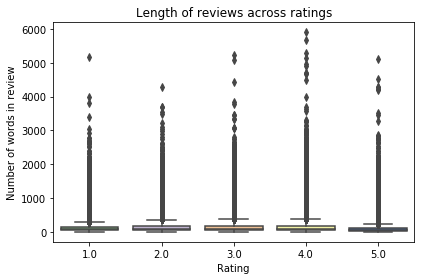

In [21]:
# create boxplot to visualize word count across rating buckets
ax = sns.boxplot(x='overall',y='word_count',data=df_engineered, palette='Accent')
ax.set(title='Length of reviews across ratings')
ax.set(xlabel='Rating',ylabel='Number of words in review')
plt.tight_layout()
# plt.savefig()

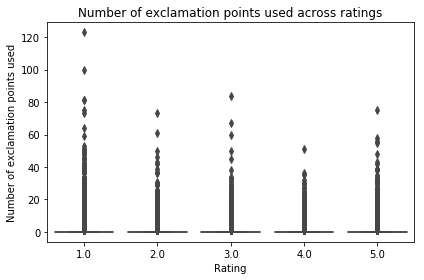

In [22]:
# create boxplot to visualize number of exclamation points across rating buckets
ax = sns.boxplot(x='overall',y='exclamation_count',data=df_engineered, palette='Accent')
ax.set(title='Number of exclamation points used across ratings')
ax.set(xlabel='Rating',ylabel='Number of exclamation points used')
plt.tight_layout()